# DEA comparison with Li et al.

https://genomebiology.biomedcentral.com/articles/10.1186/s13059-022-02648-4

Li et al. used 1% FDR threshold with edgeR QLF unpaired

In [33]:
import sys
import os
import glob
import pickle
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
from enum import Enum

datapath = Path("../data")

modpath = Path("../scripts")
sys.path.append(os.path.relpath(modpath))

from misc import Timer, pickler, open_table
import plot_utils
npg = plot_utils.npg_palette(); jco = plot_utils.jco_palette(); colors=plot_utils.matplotlib_init()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [34]:
from DEA import run_dea

class PermuteMode(Enum):
    
    NONE = 1
    RANDOM = 2
    BALANCED = 3
    
sites = {"thyroid": "THCA",
         "lung": "LUAD",
         "kidney": "KIRC",
         "colorectal": "COAD",
         "breast": "BRCA",
         "liver": "LIHC",
         "prostate": "PRAD"}

def subsample_df(df_full, N):
        replicates = len(df_full.columns)//2
        p = sorted(np.random.choice(range(1,replicates), N, replace=False))
        p += [pi+replicates for pi in p]    
        return df_full.iloc[:,p]   

def permute_df(df):    
    ix = list(df.columns)
    random.shuffle(ix)
    return df[pd.Index(ix)]

# quick and dirty implementation
def permute_balanced(df):
    """Make sure each permuted (fake) condition has equal number of control/treatment"""
    replicates = len(df.columns)//2
    
    if replicates % 2 != 0:
        raise Exception("Must have even number of samples")
        
    # Take first quarter of samples and swap with random treatment samples, now both conditions have equal number of control/treatment samples
    col_ix = list(range(2*replicates))
    rnd_treat_ix = np.random.choice(range(replicates, 2*replicates), replicates//2, replace=False)

    for i, j in zip(col_ix[:replicates//2], rnd_treat_ix):
        col_ix[i], col_ix[j] = col_ix[j], col_ix[i]

    cols = df.columns.values
    cols = list(cols[col_ix])
    df = df[cols]
    
    # Shuffle within each fake condition
    df_c = df.iloc[:,:replicates]
    df_c = permute_df(df_c)
    
    df_t = df.iloc[:,replicates:]
    df_t = permute_df(df_t)
    
    df = pd.concat([df_c,df_t], axis=1)
    
    if get_imbalance_ratio(df) != 0.5:
        display(df)
        raise Exception("Balancing failed")
    return df

def get_imbalance_ratio(df):
    """Return ratio of true control samples in fake control group (same as fake treatment group)"""
    replicates = len(df.columns)//2
    return sum([1 if colname.startswith("N") else 0 for colname in df.columns[:replicates]]) / replicates

def run_dea_here(df, dea, lfc=0, GSE91061=False):

    DEA_kwargs = {
        "edgerqlf": {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"]},
        "edgerlrt": {"filter_expr": False, "cols_to_keep": ["logFC","logCPM","FDR"], "test":"lrt"},
        "deseq2": {"cols_to_keep": ["logFC","logCPM","FDR"]}
    }
   
    outfile = "/storage/homefs/pd21v747/datanew/test/dea_test.csv"

    run_dea(df, outfile, dea, overwrite=True, design="GSE91061" if GSE91061 else "unpaired", lfc=lfc, **DEA_kwargs[dea])
    return pd.read_csv(outfile, index_col=0)

In [44]:
site = "prostate"
data = sites[site]

permute = PermuteMode.RANDOM
subsample = True
N = 6

f = datapath / f"{site}/{data}/{data}.csv"
#f = "/storage/homefs/pd21v747/datanew/GSE91061/GSE91061_BMS038109Sample.hg19KnownGene.raw.csv"

GSE91061 = "GSE91061" in str(f)

df_full = pd.read_csv(f, index_col=0, header=0)

print("Running on " + ("GSE91061" if GSE91061 else "TCGA") + " data")

if(GSE91061):
    pre = list(df_full.columns)
    pre = [p for p in pre if "_Pre_" in p]
    on = df_full.columns.difference(set(pre))
    ix = pd.Index(pre+list(on))
    df_full = df_full[ix]

df_full

Running on TCGA data


,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52
ENSG00000000003,3913,4568,7104,7692,3002,3313,3926,3117,6964,1467,...,6379,4384,4717,4556,4856,7170,7325,4697,4024,8809
ENSG00000000419,1164,1607,2043,1931,1329,1594,1378,1663,2853,1855,...,1762,1657,1201,2174,2083,1456,1290,1027,1617,2954
ENSG00000000457,959,1215,1643,1817,1082,1028,1147,1334,1727,886,...,1507,2060,1057,1669,2139,1292,1151,699,1084,1258
ENSG00000000460,173,194,297,304,299,207,228,278,239,199,...,306,237,262,339,256,189,345,172,292,171
ENSG00000000938,231,234,496,119,419,605,547,409,580,352,...,463,138,203,526,195,302,262,343,173,329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000281571,30,21,45,20,22,25,15,11,40,12,...,34,56,34,17,21,39,32,34,22,81
ENSG00000281649,3850,4769,6607,9611,4702,3541,5692,4845,6766,2631,...,6146,6546,5314,7317,6360,6068,7782,7557,4706,6929
ENSG00000281896,23,38,51,39,29,47,26,40,50,15,...,27,35,21,69,42,34,40,13,28,24
ENSG00000281903,6,16,20,35,25,12,22,17,19,3,...,9,21,8,14,22,12,32,35,11,12


# Balanced vs imbalanced permutations

In [ ]:
overwrite = 0

FDR = 0.01
all_N = [4,8,16,32,"all"]

permute_modes = [PermuteMode.RANDOM, PermuteMode.BALANCED, PermuteMode.NONE]

if "sig_dict" not in globals():
    
    if os.path.isfile("../data/misc/permuted_degs.txt"):
    
        with open("../data/misc/permuted_degs.txt", "rb") as f:
            sig_dict = pickle.load(f)
            print("Loaded sig dict")
    
    else:
        sig_dict = {site:{p: {N:None for N in all_N} for p in permute_modes} }

if site not in sig_dict:
    sig_dict[site] = {p: {N:None for N in all_N} for p in permute_modes}

is_dirty = False

with Timer(name="context manager"):
    for N in all_N:

        df = df_full if (N == "all") else subsample_df(df_full, N)
            
        for permute_mode in permute_modes:

            if not overwrite and sig_dict[site][permute_mode][N] != None:
                print("Skipped existing calculation: ", site, N, permute_mode)
                continue

            is_dirty = True

            if permute_mode == PermuteMode.BALANCED:
                
                if len(df.columns)//2 % 2 != 0:
                    drop_patient = df.columns[0]
                    df = df.drop([drop_patient, drop_patient.replace("N","T")], axis=1)
                    print("Dropping one patient, now df has", len(df.columns), "cols")
                    
                df_perm = permute_balanced(df) # re-use subsampled df, so avoid conflict with random permuted df
                
            elif permute_mode == PermuteMode.RANDOM:
                df_perm = permute_df(df)

            res = run_dea_here(df_perm, "edgerqlf")

            sig = res[res["FDR"]<FDR]
            sig_dict[site][permute_mode][N] = len(sig)
            print(N, sig_dict[site][permute_mode][N])
        
if is_dirty:
    pickler(sig_dict, "../data/misc/permuted_degs.txt")
    print("Saving sig dict")

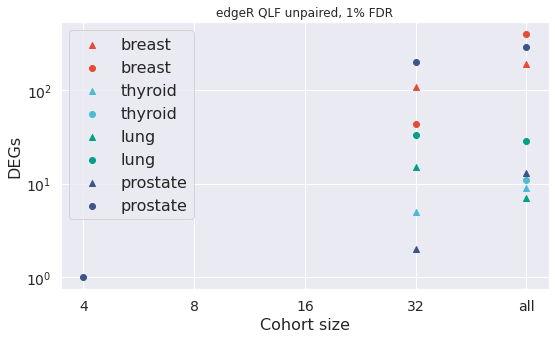

In [5]:
if "sig_dict" not in globals():
    with open("/../data/misc/permuted_degs.txt", "rb") as f:
        sig_dict = pickle.load(f)
        print("Loaded sig dict")


fig, ax = plt.subplots(1,1,figsize=(8,5))


for i, site in enumerate(sig_dict):
    
    color = npg[i]
    
    for j, permute_mode in enumerate(permute_modes):
        
        if permute_mode == PermuteMode.NONE:
            continue
            
        marker = "o" if permute_mode == PermuteMode.BALANCED else "^"
    
        for k, N in enumerate(all_N):

            ax.scatter(k,sig_dict[site][permute_mode][N],color=color,label=site if k == 0 else None, marker=marker)
        
ax.set(xlabel="Cohort size", ylabel="DEGs", title="edgeR QLF unpaired, 1% FDR")
ax.set_xticks(range(len(all_N)))
ax.set_xticklabels(all_N)
ax.legend()
ax.set_yscale("log")

figpath = f"../figures/permuted_degs.pdf"
fig.tight_layout()
fig.savefig(figpath)

# DEGs vs imbalance ratio

In [ ]:
overwrite = False

trials = 10 # about 420 seconds per trial
fdr = 0.05
all_N = [8,16,32,'all']

# don't change LFC; we only check if N, site and trial is already computed
lfcs = [0,1]
post_lfcs = [0,1]

balanced = False

if "combined" not in globals():
    
    if os.path.isfile(f"../data/misc/imba.{fdr}.csv"):
        combined = pd.read_csv(f"../data/misc/imba.{fdr}.csv")
        print("Loaded existing table")

    else:
        combined = pd.DataFrame(columns=["Site","N","Trial","Balance Ratio","DEGs","logFC","IsPermuted"])
        print("Created new table")

trials_to_run = trials - (0 if len(combined["Trial"]) < 1 else max(combined["Trial"]))
total_jobs = len(all_N) * len(sites) * trials_to_run * len(lfcs)
jobs_finished = 0

is_dirty = False
verbose = True

with Timer(name="context manager"):
    
    for site in sites:
        
        data = sites[site]
        f = datapath + f"/{site}/{data}/{data}.csv"
        df_full = pd.read_csv(f, index_col=0, header=0)
            
        for N in all_N:

            df = df_full if (N == "all") else subsample_df(df_full, N)
            
            for lfc in lfcs: # formal fold change threshold
            
                for trial in range(trials):
                    
                    for is_permuted in [True, False]:
                        
                        if is_permuted:
                            continue

                        row = combined[(combined["N"].isin([N,str(N)]))&(combined["Site"]==site)&(combined["Trial"]==trial) 
                                       & combined["logFC"].isin([f"{lfc}.p1",f"{lfc}.p0"])
                                       & (combined["IsPermuted"] == False)]

                        if not overwrite and len(row) > 0 or (not is_permuted and N == "all" and trial > 0):
                            if verbose:
                                print("Skipped existing calculation: ", site, N, trial, is_permuted)
                            continue

                        is_dirty = True

                        if balanced and is_permuted:
                            if len(df.columns)//2 % 2 != 0:
                                drop_patient = df.columns[0]
                                df = df.drop([drop_patient, drop_patient.replace("N","T")], axis=1)
                                print("Dropping one patient to force even parity, now df has", len(df.columns), "cols")

                        if is_permuted:
                            df_perm = permute_balanced(df) if balanced else permute_df(df)
                        else:
                            df_perm = df
                            
                        imbalance_ratio = get_imbalance_ratio(df_perm)
                        res = run_dea_here(df_perm, "edgerqlf", lfc=lfc)

                        for post_lfc in post_lfcs: # post hoc fold change threshold

                            if lfc == 1 and post_lfc == 1: # skip redundant calculation
                                continue

                            sig = res[(res["FDR"]<fdr) & (res["logFC"].abs()>post_lfc)]

                            lfc_name = f"{lfc}.p{post_lfc}"

                            new_row = {'N':N, 'Site':site, 'Trial':trial, 'Balance Ratio': imbalance_ratio, "DEGs": len(sig), "logFC": lfc_name, "IsPermuted":is_permuted}
                            combined = combined.append(new_row, ignore_index=True)

                            jobs_finished += 1
                            print(f"{jobs_finished} out of {total_jobs} finished: ", N, site, trial, lfc, post_lfc, len(sig), imbalance_ratio, is_permuted)
        
combined = combined.drop([col for col in combined.columns if "Unnamed" in col], axis=1)

if is_dirty:
    combined.to_csv(f"../data/misc/imba.{fdr}.csv")
    print("Saving table")

In [ ]:
fdr = 0.05
if "combined" not in globals():
    combined = pd.read_csv(f"../data/misc/imba.{fdr}.csv")
    print("Loaded table")
    

fig, ax = plt.subplots(1,1,figsize=(10,5))

N = 32

combined_N = combined[combined["N"].isin([N,str(N)])]

sns.scatterplot(data=combined_N, x="Balance Ratio", y="DEGs", hue="Site", ax=ax)

ax.set(xlabel="Ratio of control samples in permuted control group", ylabel="DEGs", title=f"edgeR QLF unpaired, 1% FDR, N={N}")
ax.legend(bbox_to_anchor=(1, 1), fancybox=True, shadow=False, ncol=1,fontsize=14,framealpha=1)
ax.set_yscale("log")

figpath = f"../figures/degs_vs_imbalance_ratio.{fdr}.pdf"
fig.tight_layout()
fig.savefig(figpath)

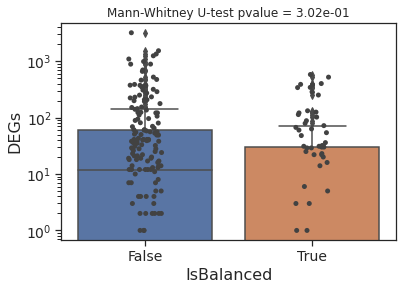

In [48]:
from scipy.stats import mannwhitneyu

N = 32

combined_N = combined[combined["N"].isin([N,str(N)])]

balanced_degs = combined_N[combined_N["IsBalanced"]]["DEGs"]
imbalanced_degs = combined_N[~combined_N["IsBalanced"]]["DEGs"]
U1, p = mannwhitneyu(balanced_degs, imbalanced_degs)

sns.boxplot(data=combined, x= "IsBalanced", y = "DEGs")
sns.stripplot(data=combined, x= "IsBalanced", y = "DEGs", color="#424242")
plt.yscale("log")
plt.title(f"Mann-Whitney U-test pvalue = {p:.2e}")
fig.tight_layout()
fig.savefig(figpath)
figpath = f"../figures/balanced_vs_imbalanced_degs.pdf"

<AxesSubplot:xlabel='IsBalanced', ylabel='DEGs'>

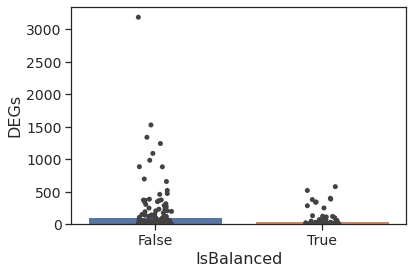

In [46]:
sns.barplot(data=combined, x= "IsBalanced", y = "DEGs")
sns.stripplot(data=combined, x= "IsBalanced", y = "DEGs", color="#424242")

# Wilcoxon

In [74]:
from scipy.stats import ranksums
from DEA import normalize_counts
from statsmodels.stats.multitest import multipletests
import scipy
scipy.__version__

'1.6.3'

In [ ]:
overwrite = 0

site = "breast"
fdr = 0.05
trials = 1

if "comb_wilcox" not in globals():
    
    if os.path.isfile(f"../data/misc/comb_wilcox.{fdr}.csv"):
        comb_wilcox = pd.read_csv(f"../data/misc/comb_wilcox.{fdr}.csv")
        print("Loaded existing table")

    else:
        comb_wilcox = pd.DataFrame(columns=["Site","Trial","IsPermuted","Balance Ratio","DEGs"])
        print("Created new table")
        
is_dirty = False

with Timer(name="context manager"):
    for site in sites:
        data = sites[site]
        f = datapath + f"/{site}/{data}/{data}.csv"
        df_full = pd.read_csv(f, index_col=0, header=0)
        
        for trial in range(trials):

            row = comb_wilcox.query(f"Site == '{site}' and Trial == {trial}")

            if not overwrite and len(row) > 0:
                print("Skipped existing calculation: ", site, trial)
                continue

            is_dirty = True
                
                
            for isPermuted in [True, False]:

                df = permute_df(df_full) if isPermuted else df_full
                df_norm = normalize_counts(df)

                df_N = df_norm.iloc[:,:len(df_norm.columns)//2]
                df_T = df_norm.iloc[:,len(df_norm.columns)//2:]

                pvals = []
                for i in range(len(df_N)):
                    res = ranksums(df_N.iloc[i], df_T.iloc[i])
                    pvals.append(res[1])

                FDR = multipletests(pvals, method="fdr_bh")[1]
                sig = FDR[FDR<fdr]
                
                imbalance_ratio=get_imbalance_ratio(df_norm)
                
                print(site,trial,isPermuted,len(sig),imbalance_ratio)
                

                new_row = {'Site':site, 'Trial':trial, 'IsPermuted': isPermuted, 'Balance Ratio': imbalance_ratio, "DEGs": len(sig)}
                comb_wilcox = comb_wilcox.append(new_row, ignore_index=True)
                
if is_dirty:
    comb_wilcox.to_csv(f"../data/misc/comb_wilcox.{fdr}.csv")
    print("Saving table")

# Permutated DEGs vs N

In [45]:
npg = plot_utils.npg_palette(); jco = plot_utils.jco_palette(); colors=plot_utils.matplotlib_init()
sns.set_style("ticks")

In [62]:
datasetsfile = "../data/multi/datasets_wilcox.txt"
with open(datasetsfile, "rb") as f:
    datasets = pickle.load(f)
    
DEAs = ["edgerlrt", "edgerqlf", "deseq2"]
outlier_methods = ["none","jk","pcah"]
all_N = [3,4,5,6,7,8,9,10,12,15]

# pretty names
prdea = {"edgerlrt":"edgeR LRT","edgerqlf":"edgeR QLF","deseq2":"DESeq2"}
prout = {"none":"None","jk":"Jackknife","pcah":"rPCA"}

In [63]:
FDRs, logFCs = [0.05], [0,1, "post hoc"]
DEAs = ["edgerqlf", "edgerlrt", "deseq2"]

iterables = [datasets,[prdea[d] for d in DEAs],FDRs,logFCs]
multi_cols = pd.MultiIndex.from_product(iterables, names=["Data","DEA","FDR","logFC"])
gt = pd.DataFrame(columns=multi_cols)
for data in datasets:
    for dea in DEAs:
        for fdr in FDRs:
            for lfc in logFCs:
                col = (data,prdea[dea],fdr,lfc)
                if lfc == "post hoc":
                    gt.loc[0,col] = datasets[data]["truth_stats"][0][fdr][1][dea]
                else:
                    gt.loc[0,col] = datasets[data]["truth_stats"][lfc][fdr][lfc][dea]
                    
gt=gt.unstack().reset_index(level=["Data","DEA","FDR","logFC"], drop=False)
gt.sort_values(by="DEA", inplace=True)
gt.rename(columns={0: "#DEG"}, inplace=True)

gt=gt[gt["Data"]!="KIRC_syn_hom"]
gt["#DEG"] = gt["#DEG"].astype(float)
df = gt
df.index = range(len(df))

In [64]:
full = df[(df["DEA"]=="edgeR QLF")&(df["logFC"]==0)&(df["FDR"]==0.05)]
cancers = ["THCA","PRAD","BRCA","LUAD","COAD","LIHC","KIRC"]
full = full[full["Data"].isin(cancers)]
full["#DEG"].median()

11978.0

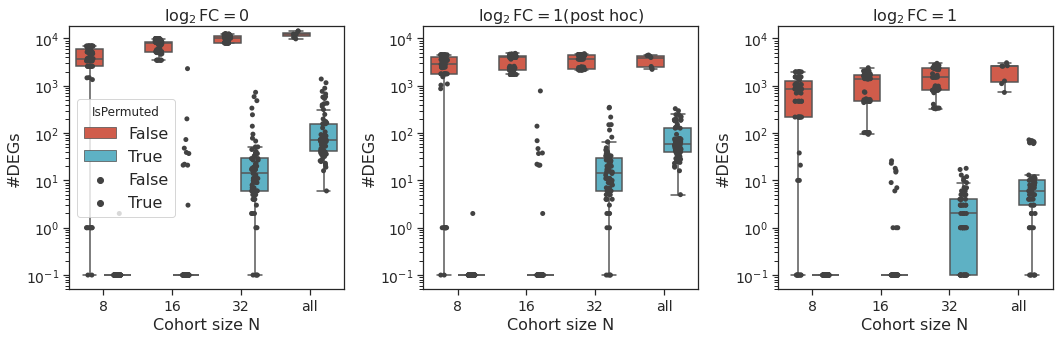

In [70]:
fdr = 0.05
if "combined" not in globals():
    combined = pd.read_csv(f"../data/misc/imba.{fdr}.csv", index_col=0)
    print("Loaded table")
    

fig, ax = plt.subplots(1,3,figsize=(15,5), sharey=False, sharex=False)

cc = combined

median_unpermuted_deg = full["#DEG"].median() #np.nanmedian(cc[cc["N"]=="unpermuted"]["DEGs"].values)

cc = cc[cc["Site"]!="synthetic"]
#cc = cc[cc["N"]!="unpermuted"]
cc.loc[cc[cc["DEGs"]<1].index,"DEGs"] = 0.1
cc["N"] = cc["N"].astype(str)

cc["IsBalanced"] = cc["Balance Ratio"].isin([0.5,1.0])

hue="IsPermuted"

for a, lfc in zip(ax, ["0.p0","0.p1","1.p0"]):
    
    ccc = cc[cc["logFC"]==lfc]
    
    sns.boxplot(data=ccc, x="N", y="DEGs", ax=a,hue=hue, dodge=True, palette=npg, fliersize=0)
    sns.stripplot(data=ccc, x= "N", y = "DEGs", ax=a, hue=hue, dodge=True, palette=["#424242","#424242"])

    a.set(xlabel="Cohort size N", ylabel="#DEGs", title=f"edgeR QLF unpaired, {fdr:.0%} FDR")
    a.set_yscale("log")    
    #a.axhline(median_unpermuted_deg,ls="--",color="black",alpha=0.8)
    
    #a.annotate(lfc, (0.91,0.95), xycoords="axes fraction", va='center',ha='center', fontsize=14)
    #a.annotate("Unpermuted", (0.5,0.92), xycoords="axes fraction", va='center',ha='center', fontsize=14)
    
    lfc_name = str(int(lfc.split(".")[0])+int(lfc.split(".")[1][1])) + ( "(post hoc)" if lfc.split(".")[1][1]=="1" else "")
    a.set_title(rf"$\log_2\mathrm{{FC}}=${lfc_name}", fontsize=16)
    
    if a != ax[0]:
        a.legend([],[],frameon=False)
    else:
        a.legend(title=hue, loc="best")#bbox_to_anchor=(1, 1), fancybox=True, shadow=False, ncol=1,fontsize=14,framealpha=1)
        
    a.set_ylim(0.05,18000)

#figpath = f"../figures/permuted_degs_vs_N.{fdr}.pdf"
fig.tight_layout()
#fig.savefig(figpath)

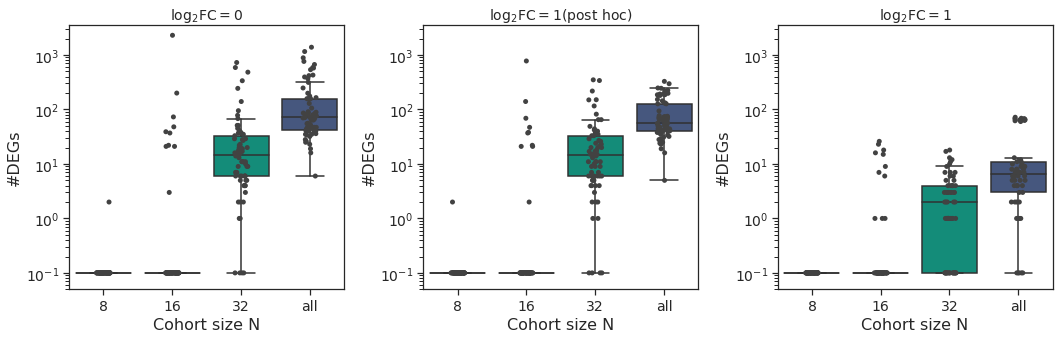

In [35]:
fdr = 0.05
if "combined" not in globals():
    combined = pd.read_csv(f"../data/misc/imba.{fdr}.csv")
    print("Loaded table")
    

fig, ax = plt.subplots(1,3,figsize=(15,5), sharey=False, sharex=False)

cc = combined

median_unpermuted_deg = full["#DEG"].median() #np.nanmedian(cc[cc["N"]=="unpermuted"]["DEGs"].values)

cc = cc[cc["Site"]!="synthetic"]
#cc = cc[cc["N"]!="unpermuted"]
cc.loc[cc[cc["DEGs"]<1].index,"DEGs"] = 0.1
cc["N"] = cc["N"].astype(str)

cc["IsBalanced"] = cc["Balance Ratio"].isin([0.5,1.0])

for a, lfc in zip(ax, ["0.p0","0.p1","1.p0"]):
    
    ccc = cc[cc["logFC"]==lfc]
    
    sns.boxplot(data=ccc, x="N", y="DEGs", ax=a, dodge=True, palette=npg, fliersize=0)
    sns.stripplot(data=ccc, x= "N", y = "DEGs", ax=a, dodge=True, palette=["#424242","#424242"])

    a.set(xlabel="Cohort size N", ylabel="#DEGs")
    a.set_yscale("log")    
    #a.axhline(median_unpermuted_deg,ls="--",color="black",alpha=0.8)
    
    lfc_name = str(int(lfc.split(".")[0])+int(lfc.split(".")[1][1])) + ( "(post hoc)" if lfc.split(".")[1][1]=="1" else "")
    a.set_title(rf"$\log_2\mathrm{{FC}}=${lfc_name}", fontsize=14)
    #a.annotate("Unpermuted", (0.5,0.92), xycoords="axes fraction", va='center',ha='center', fontsize=14)

    a.legend([],[],frameon=False)
        
    a.set_ylim(0.05,3500)

figpath = f"../figures/permuted_degs_vs_N.{fdr}.pdf"
fig.tight_layout()
fig.savefig(figpath)

In [ ]:
# 2nd panel logFC cutoff
# unpermuted for different N

In [25]:
# full = df[(df["DEA"]=="edgeR QLF")&(df["logFC"]==0)&(df["FDR"]==0.05)]
# full.head()

# c = combined
# inv_sites = {value: key for key, value in sites.items()}

# for f in full.index:
#     degs = full.loc[f,"#DEG"]
#     data = full.loc[f,"Data"]
#     new_row = {'N':"unpermuted",'Site':inv_sites[data], 'Trial':-1, 'IsPermuted': False, 'Balance Ratio': 1, "DEGs": degs}
#     c = c.append(new_row, ignore_index=True)

In [24]:
#df = df.sort_values(by=['Data',"DEA"], key=lambda col: col.map(kf))